## dataset

In [2]:
import os, time, math
import torch
from torch import optim, nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print('GPU:', torch.cuda.is_available())

device = torch.device('cuda')

GPU: False


In [4]:
raw_data = []
with open('lstm-label.txt', 'r') as f:
  lines = f.readlines()[:120]
  for line in lines:
    attrs_num = line.rstrip().split(': ')[1].split(' ')
    atrrs_num = [int(x) for x in attrs_num]
    raw_data.append(attrs_num)
all_data = np.array(raw_data, dtype='float32')
all_data = all_data.T
all_data, all_data.shape

(array([[520., 520., 545., ..., 203., 213., 201.],
        [305., 289., 309., ..., 176., 182., 184.],
        [ 42.,  40.,  43., ..., 130., 127., 122.],
        ...,
        [129., 119., 120., ...,  20.,  20.,  18.],
        [ 78.,  72.,  77., ..., 115., 118., 128.],
        [ 70.,  64.,  66., ...,  51.,  54.,  55.]], dtype=float32),
 (30, 120))

In [5]:
trend_data3, trend_data5 = [], []
for data in all_data:
  row = []
  for i in range(len(data) - 3):
    row.append(data[i+3] - (data[i]+data[i+1]+data[i+2])/3)
  trend_data3.append(row)

for data in all_data:
  row = []
  for i in range(len(data) - 5):
    row.append(data[i+5] - (data[i]+data[i+1]+data[i+2]+data[i+3]+data[i+4])/5)
  trend_data5.append(row)

trend_data3 = np.array(trend_data3, dtype='float32')
trend_data5 = np.array(trend_data5, dtype='float32')
print(trend_data3, trend_data3.shape)
print(trend_data5, trend_data5.shape)

[[-18.333334  -46.         13.666667  ...  -9.666667    9.
   -5.       ]
 [-16.        -30.333334    2.        ...  -7.3333335   2.
    4.       ]
 [ -4.6666665  -4.          8.333333  ...   0.6666667  -1.
   -6.       ]
 ...
 [ -5.6666665  -2.6666667  -0.6666667 ...  -2.6666667  -1.6666666
   -2.6666667]
 [ -7.6666665 -36.333332   20.666666  ...  -5.3333335   1.3333334
   11.666667 ]
 [ -7.6666665  -6.          6.3333335 ...  -2.3333333   2.6666667
    2.3333333]] (30, 117)
[[ 10.2  24.2  10.2 ... -31.    0.   -9.8]
 [ -2.4   1.    4.2 ... -14.4   0.6   2.4]
 [  7.4   2.4   0.8 ...  -2.   -3.6  -7. ]
 ...
 [ -3.2   1.2   1.2 ...  -3.4  -2.2  -3.6]
 [ 14.8  14.2  22.4 ... -11.6  -2.6   9.2]
 [  3.8  10.4   3.6 ...  -4.8   0.6   2. ]] (30, 115)


In [6]:
def create_dataset(data, days_for_train=5) -> (np.array, np.array):
  dataset_x, dataset_y = [], []
  for i in range(len(data)-days_for_train):
    _x = data[i:(i+days_for_train)]
    dataset_x.append(_x)
    dataset_y.append(data[i+days_for_train]) # 更改days_for_train可以预测N天后的
  return (np.array(dataset_x), np.array(dataset_y))

def create_train_data(all_data, days_for_train, train_size):
  for data in all_data[:, :train_size+days_for_train]:
    dataset_x, dataset_y = create_dataset(data, days_for_train)
    train_x = dataset_x.reshape(-1, 1, days_for_train)
    train_y = dataset_y.reshape(-1, 1, 1)
    train_x = torch.from_numpy(train_x)
    train_y = torch.from_numpy(train_y)
    yield train_x, train_y

## practice lstm of pytorch

In [7]:
class LSTM_Regression(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=2): #【output_size：输出序列长度可以改变】
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.5) 

  def forward(self, _x):
    x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
    x = self.dropout(x)
    s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
    x = x.view(s*b, h)
    x = self.fc(x)
    x = x.view(s, b, -1)  # 把形状改回来
    return x

### train raw data

In [ ]:
min_data = all_data.min(axis=1)
max_data = all_data.max(axis=1)
data_norm = ((all_data - np.reshape(min_data, (30, 1)))) / np.reshape(max_data - min_data, (30, 1))
print(data_norm.shape)
data_norm[0]

(30, 120)


array([0.8242894 , 0.8242894 , 0.8888889 , 0.79844964, 0.71834624,
       0.8372093 , 0.875969  , 0.8501292 , 0.7881137 , 0.95607233,
       0.81395346, 0.70542634, 0.77002585, 0.7751938 , 0.749354  ,
       0.89664084, 0.8475452 , 0.751938  , 0.6795866 , 0.6408269 ,
       0.8914729 , 0.8475452 , 0.95348835, 1.        , 0.81395346,
       0.67183465, 0.7260982 , 0.8630491 , 0.79844964, 0.7622739 ,
       0.93540055, 0.81136954, 0.81395346, 0.82687336, 0.81653744,
       0.81395346, 0.81395346, 0.81395346, 0.81136954, 0.81136954,
       0.81136954, 0.751938  , 0.7260982 , 0.5167959 , 0.12661499,
       0.49612403, 0.46770027, 0.3617571 , 0.34108528, 0.51937985,
       0.53488374, 0.60723513, 0.53229976, 0.4237726 , 0.37209302,
       0.59173125, 0.5994832 , 0.4857881 , 0.54780364, 0.49612403,
       0.37726098, 0.39534885, 0.5271318 , 0.47028422, 0.42118862,
       0.5736434 , 0.5167959 , 0.3488372 , 0.31782946, 0.35658914,
       0.35917312, 0.374677  , 0.4521964 , 0.3385013 , 0.29715

In [ ]:
DAYS_FOR_TRAIN = 3
TRAIN_SIZE = 75
epochs = 1000
lr = 1e-2

index=19

data_x1, data_y1 = create_dataset(data_norm[index][:31], DAYS_FOR_TRAIN)
data_x2, data_y2 = create_dataset(data_norm[index][31:], DAYS_FOR_TRAIN)
data_x = np.vstack((data_x1, data_x2))
data_y = np.append(data_y1, data_y2)
print(data_x.shape, data_y.shape)

train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
train_y = torch.from_numpy(data_y[:TRAIN_SIZE].reshape(-1, 1, 1))
test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
test_y = torch.from_numpy(data_y[TRAIN_SIZE:].reshape(-1, 1, 1))

model = LSTM_Regression(DAYS_FOR_TRAIN, 2, output_size=1, num_layers=2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(epochs):
  out = model(train_x)
  loss = loss_function(out, train_y)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  if (i+1) % 100 == 0:
    model.eval()
    test_out = model(test_x)
    test_loss = loss_function(test_out, test_y)
    torch.save(model.state_dict(), f'model/epoch_{i+1}.pth')
    print('Epoch: {}, Train Loss:{:.5f}, Test Loss:{:.5f}'.format(i+1, loss.item(), test_loss.item()))
    model.train()

(89, 3) (89,)
Epoch: 100, Train Loss:0.03268, Test Loss:0.07689
Epoch: 200, Train Loss:0.03039, Test Loss:0.07114
Epoch: 300, Train Loss:0.02890, Test Loss:0.06596
Epoch: 400, Train Loss:0.02786, Test Loss:0.06208
Epoch: 500, Train Loss:0.02700, Test Loss:0.05885
Epoch: 600, Train Loss:0.02613, Test Loss:0.05567
Epoch: 700, Train Loss:0.02498, Test Loss:0.05182
Epoch: 800, Train Loss:0.02326, Test Loss:0.04677
Epoch: 900, Train Loss:0.02087, Test Loss:0.04062
Epoch: 1000, Train Loss:0.01832, Test Loss:0.03415


torch.Size([89, 1, 3])


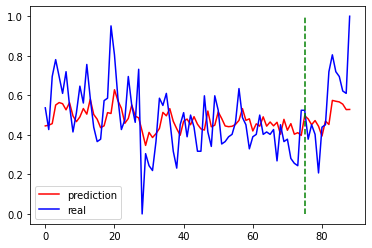

In [ ]:
all_data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
all_data_x = torch.from_numpy(all_data_x)
print(all_data_x.shape)

model.eval()
pred_test = model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
# pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
# assert len(pred_test) == len(data_norm[0])

plt.plot(pred_test, 'r', label='prediction')
plt.plot(data_y, 'b', label='real')
plt.plot((TRAIN_SIZE, TRAIN_SIZE), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

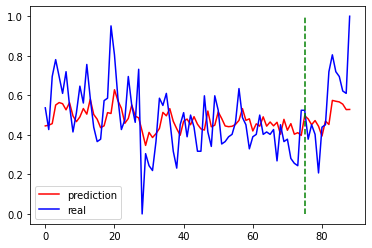

In [ ]:
predict_model = LSTM_Regression(DAYS_FOR_TRAIN, 2, output_size=1, num_layers=2)
predict_model.load_state_dict(torch.load('model/epoch_1000.pth'))
predict_model = predict_model.eval()

pred_test = predict_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()

plt.plot(pred_test, 'r', label='prediction')
plt.plot(data_y, 'b', label='real')
plt.plot((TRAIN_SIZE, TRAIN_SIZE), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

In [ ]:
predict_10 = []
last_array = data_norm[index][:31][-3:]
last = torch.from_numpy(last_array.reshape(-1, 1, 3))
for i in range(10):
  print(i, last)
  new_data = model(last)
  dix = float(new_data)
  pre_data = dix * (max_data[index] - min_data[index]) + min_data[index]
  predict_10.append(round(pre_data))
  last_array = np.append(np.delete(last_array, 0), new_data.detach().numpy())
  last = torch.from_numpy(last_array.reshape(-1, 1, 3))
predict_10

0 tensor([[[0.5488, 0.4634, 0.7317]]])
1 tensor([[[0.4634, 0.7317, 0.4510]]])
2 tensor([[[0.7317, 0.4510, 0.4336]]])
3 tensor([[[0.4510, 0.4336, 0.4306]]])
4 tensor([[[0.4336, 0.4306, 0.4117]]])
5 tensor([[[0.4306, 0.4117, 0.4074]]])
6 tensor([[[0.4117, 0.4074, 0.4051]]])
7 tensor([[[0.4074, 0.4051, 0.4030]]])
8 tensor([[[0.4051, 0.4030, 0.4022]]])
9 tensor([[[0.4030, 0.4022, 0.4017]]])


[123, 122, 121, 120, 119, 119, 119, 119, 119, 119]

In [ ]:
loss_ten_data.append(predict_10)
loss_ten_data

[[515, 516, 521, 517, 516, 516, 516, 515, 515, 515],
 [272, 254, 245, 234, 224, 218, 213, 210, 208, 207],
 [38, 37, 37, 36, 36, 36, 35, 35, 35, 35],
 [56, 56, 56, 56, 56, 56, 56, 56, 56, 56],
 [40, 39, 39, 39, 39, 39, 39, 39, 39, 39],
 [335, 348, 352, 354, 354, 354, 354, 354, 354, 354],
 [339, 345, 353, 341, 342, 343, 341, 342, 342, 342],
 [143, 134, 131, 131, 132, 132, 132, 132, 132, 132],
 [415, 396, 403, 404, 403, 403, 403, 403, 403, 403],
 [67, 67, 66, 66, 66, 66, 65, 65, 65, 65],
 [48, 47, 47, 47, 46, 46, 46, 46, 46, 46],
 [234, 230, 227, 226, 226, 226, 226, 226, 226, 226],
 [155, 155, 156, 156, 156, 156, 156, 156, 156, 156],
 [1476, 1452, 1462, 1494, 1499, 1494, 1489, 1489, 1490, 1490],
 [82, 81, 80, 81, 81, 81, 81, 81, 81, 81],
 [1145, 1112, 1108, 1079, 1071, 1069, 1066, 1065, 1064, 1064],
 [79, 79, 78, 78, 77, 77, 77, 77, 77, 77],
 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97],
 [101, 101, 101, 99, 99, 99, 99, 99, 99, 99],
 [123, 122, 121, 120, 119, 119, 119, 119, 119, 119]]

In [ ]:
ret = []
for index in range(20, 30):
  data_x1, data_y1 = create_dataset(data_norm[index][:31], DAYS_FOR_TRAIN)
  data_x2, data_y2 = create_dataset(data_norm[index][31:], DAYS_FOR_TRAIN)
  data_x = np.vstack((data_x1, data_x2))
  data_y = np.append(data_y1, data_y2)
  print(data_x.shape, data_y.shape)

  train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
  train_y = torch.from_numpy(data_y[:TRAIN_SIZE].reshape(-1, 1, 1))
  test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
  test_y = torch.from_numpy(data_y[TRAIN_SIZE:].reshape(-1, 1, 1))

  model = LSTM_Regression(DAYS_FOR_TRAIN, 2, output_size=1, num_layers=2)
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  for i in range(epochs):
    out = model(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
      model.eval()
      test_out = model(test_x)
      test_loss = loss_function(test_out, test_y)
      # torch.save(model.state_dict(), f'model/epoch_{i+1}.pth')
      print('Epoch: {}, Train Loss:{:.5f}, Test Loss:{:.5f}'.format(i+1, loss.item(), test_loss.item()))
      model.train()
  
  model.eval()
  predict_10 = []
  last_array = data_norm[index][:31][-3:]
  last = torch.from_numpy(last_array.reshape(-1, 1, 3))
  for i in range(10):
    print(i, last)
    new_data = model(last)
    dix = float(new_data)
    pre_data = dix * (max_data[index] - min_data[index]) + min_data[index]
    predict_10.append(round(pre_data))
    last_array = np.append(np.delete(last_array, 0), new_data.detach().numpy())
    last = torch.from_numpy(last_array.reshape(-1, 1, 3))
  print(predict_10)
  ret.append(predict_10)
ret

(89, 3) (89,)
Epoch: 100, Train Loss:0.03366, Test Loss:0.02597
Epoch: 200, Train Loss:0.03312, Test Loss:0.02595
Epoch: 300, Train Loss:0.03120, Test Loss:0.02558
Epoch: 400, Train Loss:0.02335, Test Loss:0.03401
Epoch: 500, Train Loss:0.02201, Test Loss:0.02781
Epoch: 600, Train Loss:0.01903, Test Loss:0.02751
Epoch: 700, Train Loss:0.01738, Test Loss:0.02811
Epoch: 800, Train Loss:0.01621, Test Loss:0.02908
Epoch: 900, Train Loss:0.01483, Test Loss:0.03416
Epoch: 1000, Train Loss:0.01330, Test Loss:0.03567
0 tensor([[[0.6235, 0.6235, 0.8118]]])
1 tensor([[[0.6235, 0.8118, 0.5634]]])
2 tensor([[[0.8118, 0.5634, 0.4974]]])
3 tensor([[[0.5634, 0.4974, 0.3950]]])
4 tensor([[[0.4974, 0.3950, 0.3200]]])
5 tensor([[[0.3950, 0.3200, 0.2517]]])
6 tensor([[[0.3200, 0.2517, 0.2151]]])
7 tensor([[[0.2517, 0.2151, 0.2034]]])
8 tensor([[[0.2151, 0.2034, 0.2047]]])
9 tensor([[[0.2034, 0.2047, 0.2085]]])
[119, 113, 105, 98, 92, 89, 88, 88, 89, 89]
(89, 3) (89,)
Epoch: 100, Train Loss:0.01186, Test 

[[119, 113, 105, 98, 92, 89, 88, 88, 89, 89],
 [208, 187, 189, 188, 186, 185, 185, 185, 184, 184],
 [68, 65, 62, 60, 59, 58, 58, 57, 57, 57],
 [79, 78, 78, 78, 78, 78, 78, 78, 78, 78],
 [70, 68, 67, 65, 64, 62, 60, 57, 54, 49],
 [104, 97, 95, 96, 98, 98, 97, 97, 97, 97],
 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97],
 [116, 116, 114, 114, 113, 113, 112, 112, 112, 112],
 [58, 57, 57, 57, 57, 57, 57, 57, 57, 57],
 [64, 61, 60, 57, 56, 54, 53, 52, 51, 50]]

In [ ]:
miss_data = np.array(loss_ten_data).T
for row in miss_data:
  print(' '.join([str(x) for x in row]))

515 272 38 56 40 335 339 143 415 67 48 234 155 1476 82 1145 79 97 101 123 119 208 68 79 70 104 97 116 58 64
516 254 37 56 39 348 345 134 396 67 47 230 155 1452 81 1112 79 97 101 122 113 187 65 78 68 97 97 116 57 61
521 245 37 56 39 352 353 131 403 66 47 227 156 1462 80 1108 78 97 101 121 105 189 62 78 67 95 97 114 57 60
517 234 36 56 39 354 341 131 404 66 47 226 156 1494 81 1079 78 97 99 120 98 188 60 78 65 96 97 114 57 57
516 224 36 56 39 354 342 132 403 66 46 226 156 1499 81 1071 77 97 99 119 92 186 59 78 64 98 97 113 57 56
516 218 36 56 39 354 343 132 403 66 46 226 156 1494 81 1069 77 97 99 119 89 185 58 78 62 98 97 113 57 54
516 213 35 56 39 354 341 132 403 65 46 226 156 1489 81 1066 77 97 99 119 88 185 58 78 60 97 97 112 57 53
515 210 35 56 39 354 342 132 403 65 46 226 156 1489 81 1065 77 97 99 119 88 185 57 78 57 97 97 112 57 52
515 208 35 56 39 354 342 132 403 65 46 226 156 1490 81 1064 77 97 99 119 89 184 57 78 54 97 97 112 57 51
515 207 35 56 39 354 342 132 403 65 46 226 156 1

### train trend data for three days (MA3)

In [ ]:
## 均值化
min_trend3 = trend_data3.min(axis=1)
max_trend3 = trend_data3.max(axis=1)
trend_norm3 = ((trend_data3 + np.reshape(min_trend3, (30, 1))) / np.reshape(-min_trend3, (30, 1))) + 1
trend_norm3[0], trend_norm3.shape

(array([-0.08799994, -0.22080004,  0.06560004,  0.16959995,  0.07359999,
        -0.12320006,  0.21920002, -0.09440005, -0.27359998, -0.10239995,
         0.02240002, -0.00160003,  0.24480003,  0.07520002, -0.14719999,
        -0.2831999 , -0.22080004,  0.37280005,  0.20480001,  0.29760003,
         0.1904    , -0.22239995, -0.4655999 , -0.1904    ,  0.23360002,
         0.08319998, -0.06239998,  0.23679996, -0.03840005, -0.04159999,
        -0.04960001, -0.00160003, -0.00960004, -0.00960004, -0.00160003,
        -0.00479996, -0.00320005, -0.00160003, -0.11039996, -0.12160003,
        -0.4576    , -1.        ,  0.07359999,  0.16320002, -0.00320005,
        -0.18719995,  0.24000001,  0.23679996,  0.264     , -0.03999996,
        -0.24959993, -0.27680004,  0.27680004,  0.2544    , -0.06560004,
        -0.02079999, -0.08959997, -0.2464    , -0.14559996,  0.1936    ,
         0.06879997, -0.08000004,  0.18720001,  0.0528    , -0.288     ,
        -0.30080009, -0.0704    ,  0.03359997,  0.0

In [ ]:
DAYS_FOR_TRAIN = 3
NUM_LAYERS = 2
HIDDEN_SIZE = 8

if not os.path.exists(f'model3_{DAYS_FOR_TRAIN}{NUM_LAYERS}{HIDDEN_SIZE}'):
  os.mkdir(f'model3_{DAYS_FOR_TRAIN}{NUM_LAYERS}{HIDDEN_SIZE}')

TRAIN_SIZE = 90
epochs = 1200
lr = 1e-2

attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']

attr_train_result, attr_test_result = dict(), dict()
for index in range(30):
  data_x, data_y = create_dataset(trend_norm3[index], days_for_train=DAYS_FOR_TRAIN)
  train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
  train_y = torch.from_numpy(data_y[:TRAIN_SIZE].reshape(-1, 1, 1))
  test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
  test_y = torch.from_numpy(data_y[TRAIN_SIZE:].reshape(-1, 1, 1))

  model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  ### 转换到gpu
  # model, loss_function = model.to(device), loss_function.to(device)
  # train_x, train_y = train_x.to(device), train_y.to(device)
  # test_x, test_y = test_x.to(device), test_y.to(device)
  
  attr_train_result[attributes[index]] = []
  attr_test_result[attributes[index]] = []
  for i in range(epochs):
    model.train()
    out = model(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
      model.eval()
      test_out = model(test_x)
      test_loss = loss_function(test_out, test_y)
      print('Attribute: {}, Epoch: {}, Loss:{:.5f}, Test Loss:{:.5f}'.format(attributes[index], i+1, loss.item(), test_loss.item()))
      torch.save(model.state_dict(), f'model3_{DAYS_FOR_TRAIN}{NUM_LAYERS}{HIDDEN_SIZE}/{attributes[index]}_epoch_{i+1}.pth')
      attr_train_result[attributes[index]].append(loss.item())
      attr_test_result[attributes[index]].append(test_loss.item())

for k, v in attr_test_result.items():
  print(k, [round(x, 4) for x in v])

Attribute: floral, Epoch: 100, Loss:0.01156, Test Loss:0.13779
Attribute: floral, Epoch: 200, Loss:0.01098, Test Loss:0.17471
Attribute: floral, Epoch: 300, Loss:0.00417, Test Loss:0.19997
Attribute: floral, Epoch: 400, Loss:0.00134, Test Loss:0.22289
Attribute: floral, Epoch: 500, Loss:0.00029, Test Loss:0.23583
Attribute: floral, Epoch: 600, Loss:0.00011, Test Loss:0.22754
Attribute: floral, Epoch: 700, Loss:0.00006, Test Loss:0.22446
Attribute: floral, Epoch: 800, Loss:0.00004, Test Loss:0.21765
Attribute: floral, Epoch: 900, Loss:0.00002, Test Loss:0.21447
Attribute: floral, Epoch: 1000, Loss:0.00004, Test Loss:0.21166
Attribute: floral, Epoch: 1100, Loss:0.00014, Test Loss:0.21250
Attribute: floral, Epoch: 1200, Loss:0.00025, Test Loss:0.21277
Attribute: striped, Epoch: 100, Loss:0.02766, Test Loss:0.15174
Attribute: striped, Epoch: 200, Loss:0.01704, Test Loss:0.21194
Attribute: striped, Epoch: 300, Loss:0.00589, Test Loss:0.42647
Attribute: striped, Epoch: 400, Loss:0.00356, Tes

In [ ]:
index = 1
data_x, data_y = create_dataset(trend_norm3[index], days_for_train=DAYS_FOR_TRAIN)
all_data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
all_data_x = torch.from_numpy(all_data_x)

pred_model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)

pred_model.load_state_dict(torch.load(f'model3_328/{attributes[index]}_epoch_800.pth'))
pred_model.eval()
pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.cpu().view(-1).data.numpy()

plt.figure(figsize=(12, 8))
plt.plot(pred_test, 'r', label='prediction')
plt.plot(data_y, 'b', label='real')
plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-1, 1), 'g--')
plt.legend(loc='best')
plt.title(f'{attributes[index]}_epoch_800')
plt.show()

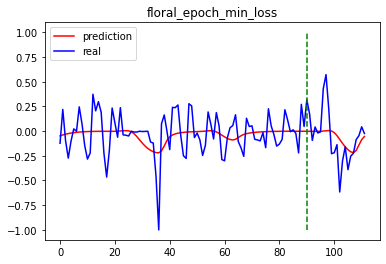

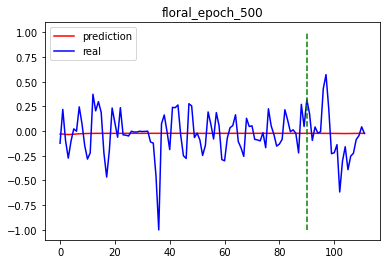

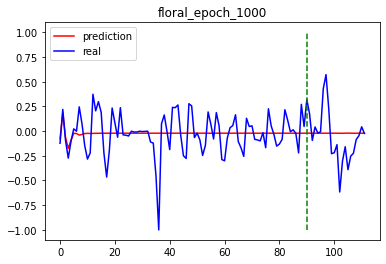

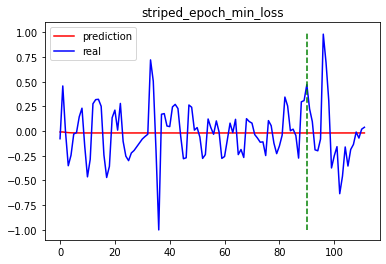

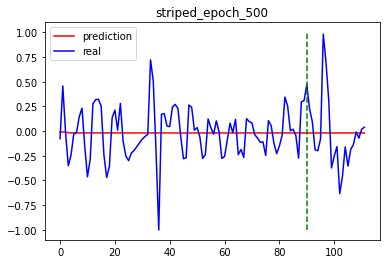

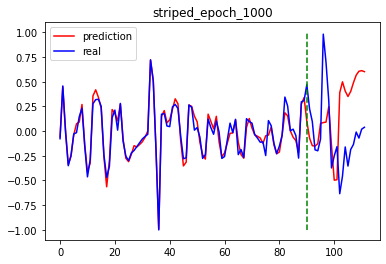

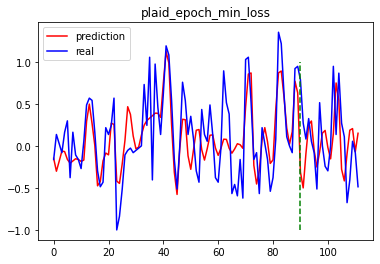

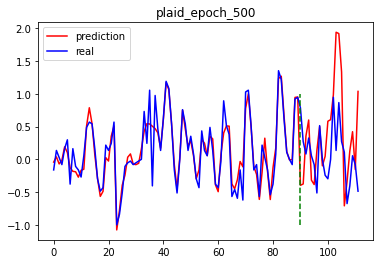

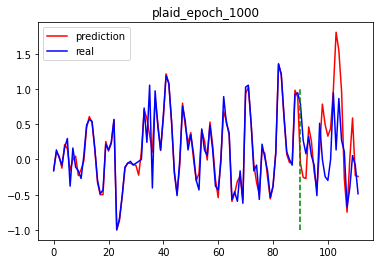

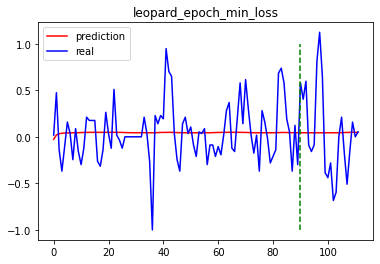

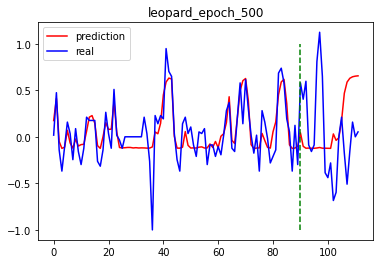

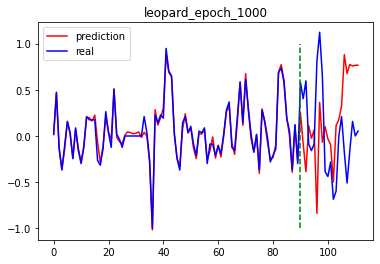

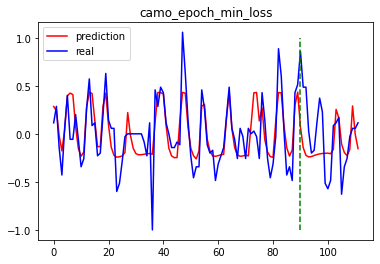

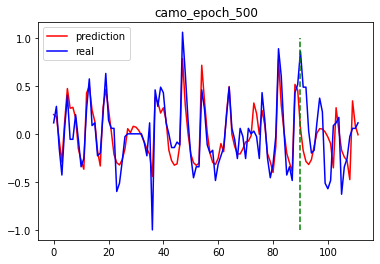

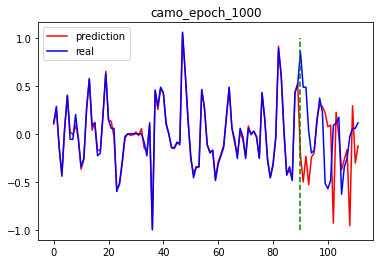

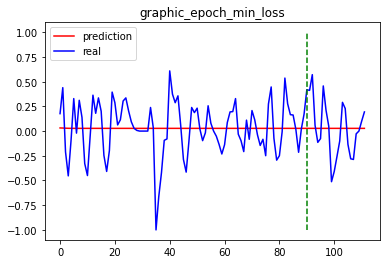

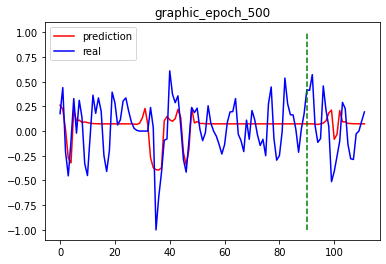

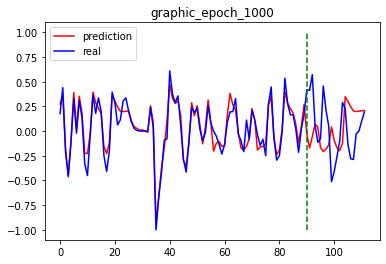

In [ ]:
for index in range(6):
  data_x, data_y = create_dataset(trend_norm3[index], days_for_train=DAYS_FOR_TRAIN)
  all_data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
  all_data_x = torch.from_numpy(all_data_x)

  pred_model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)

  all_data_x = all_data_x.to(device)
  pred_model = pred_model.to(device)

  epoch = attr_test_result[attributes[index]].index(min(attr_test_result[attributes[index]]))
  pred_model.load_state_dict(torch.load(f'model3/{attributes[index]}_epoch_{(epoch+1)*100}.pth'))
  pred_model.eval()
  pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
  pred_test = pred_test.cpu().view(-1).data.numpy()

  plt.plot(pred_test, 'r', label='prediction')
  plt.plot(data_y, 'b', label='real')
  plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-1, 1), 'g--')
  plt.legend(loc='best')
  plt.title(f'{attributes[index]}_epoch_min_loss')
  plt.show()


  pred_model.load_state_dict(torch.load(f'model3/{attributes[index]}_epoch_500.pth'))
  pred_model.eval()
  pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
  pred_test = pred_test.cpu().view(-1).data.numpy()

  plt.plot(pred_test, 'r', label='prediction')
  plt.plot(data_y, 'b', label='real')
  plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-1, 1), 'g--')
  plt.legend(loc='best')
  plt.title(f'{attributes[index]}_epoch_500')
  plt.show()


  pred_model.load_state_dict(torch.load(f'model3/{attributes[index]}_epoch_1000.pth'))
  pred_model.eval()
  pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
  pred_test = pred_test.cpu().view(-1).data.numpy()

  plt.plot(pred_test, 'r', label='prediction')
  plt.plot(data_y, 'b', label='real')
  plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-1, 1), 'g--')
  plt.legend(loc='best')
  plt.title(f'{attributes[index]}_epoch_1000')
  plt.show()

In [ ]:
for index in range(6):
  data_x, data_y = create_dataset(trend_norm3[index], days_for_train=DAYS_FOR_TRAIN)
  all_data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
  all_data_x = torch.from_numpy(all_data_x)

  pred_model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)

  all_data_x = all_data_x.to(device)
  pred_model = pred_model.to(device)
  epoch = attr_test_result[attributes[index]].index(min(attr_test_result[attributes[index]]))
  pred_model.load_state_dict(torch.load(f'model3/{attributes[index]}_epoch_{(epoch+1)*100}.pth'))
  
  pred_model.eval()
  pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
  pred_test = pred_test.cpu().view(-1).data.numpy()

  plt.plot(pred_test, 'r', label='prediction')
  plt.plot(data_y, 'b', label='real')
  plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-1, 1), 'g--')
  plt.legend(loc='best')
  plt.title(f'{attributes[index]}_epoch_min_loss predict')
  plt.show()

  pred_model.load_state_dict(torch.load(f'model3/{attributes[index]}_epoch_600.pth'))
  
  pred_model.eval()
  pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
  pred_test = pred_test.cpu().view(-1).data.numpy()

  plt.plot(pred_test, 'r', label='prediction')
  plt.plot(data_y, 'b', label='real')
  plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-1, 1), 'g--')
  plt.legend(loc='best')
  plt.title(f'{attributes[index]}_epoch_600 predict')
  plt.show()

In [ ]:
import time

TRAIN_SIZE = 90
epochs = 1500
lr = 1e-2

attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']

for DAYS_FOR_TRAIN in [1, 3, 5]:
  for NUM_LAYERS in [2, 4, 6]:
    for HIDDEN_SIZE in [4, 8, 16]:
      attr_test_result = dict()
      start = time.time()
      for index in range(30):
        data_x, data_y = create_dataset(trend_norm3[index], days_for_train=DAYS_FOR_TRAIN)
        train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
        train_y = torch.from_numpy(data_y[:TRAIN_SIZE].reshape(-1, 1, 1))
        test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
        test_y = torch.from_numpy(data_y[TRAIN_SIZE:].reshape(-1, 1, 1))

        model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        ## 转换到gpu
        model, loss_function = model.to(device), loss_function.to(device)
        train_x, train_y = train_x.to(device), train_y.to(device)
        test_x, test_y = test_x.to(device), test_y.to(device)
        
        attr_train_result[attributes[index]] = []
        attr_test_result[attributes[index]] = []
        for i in range(epochs):
          model.train()
          out = model(train_x)
          loss = loss_function(out, train_y)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          if (i+1) % 100 == 0:
            model.eval()
            test_out = model(test_x)
            test_loss = loss_function(test_out, test_y)
            attr_test_result[attributes[index]].append(test_loss.item())
      cnt, all_loss, five_loss, ten_loss = 0, 0.0, 0.0, 0.0
      for k, v in attr_test_result.items():
        cnt += (v.index(min(v)) + 1) * 100
        all_loss += math.exp(min(v))
        five_loss += math.exp(v[4])
        ten_loss += math.exp(v[9])
      print(f'seq_len: {DAYS_FOR_TRAIN}, num_layers: {NUM_LAYERS}, hid_size: {HIDDEN_SIZE}, avg_epoch: {cnt/30}, avg_loss: {all_loss/30}, five_loss: {five_loss/30}, ten_loss: {ten_loss/30}')

seq_len: 1, num_layers: 2, hid_size: 4, avg_epoch: 246.66666666666666, avg_loss: 1.0939577372225997, five_loss: 1.310751443948921, ten_loss: 1.5121610157779546
seq_len: 1, num_layers: 2, hid_size: 8, avg_epoch: 173.33333333333334, avg_loss: 1.1133266273946425, five_loss: 1.3896122161143987, ten_loss: 1.4680237808826548
seq_len: 1, num_layers: 2, hid_size: 16, avg_epoch: 186.66666666666666, avg_loss: 1.1182680578316395, five_loss: 1.262333473145916, ten_loss: 1.2825523032889883
seq_len: 1, num_layers: 4, hid_size: 4, avg_epoch: 363.3333333333333, avg_loss: 1.0897850001953298, five_loss: 1.176226970107039, ten_loss: 1.2300995143689337
seq_len: 1, num_layers: 4, hid_size: 8, avg_epoch: 143.33333333333334, avg_loss: 1.1489278725324688, five_loss: 1.407256064063454, ten_loss: 1.4106283989492205
seq_len: 1, num_layers: 4, hid_size: 16, avg_epoch: 210.0, avg_loss: 1.1189695743628616, five_loss: 1.2160995173636757, ten_loss: 1.2101926637179403
seq_len: 1, num_layers: 6, hid_size: 4, avg_epoch:

### train trend data for five days (MA5)

In [9]:
## 均值化
data_x.size()

NameError: name 'data_x' is not defined

In [8]:
## 均值化
min_trend5 = trend_data5.min(axis=1)
max_trend5 = trend_data5.max(axis=1)
trend_norm5 = ((trend_data5 + np.reshape(min_trend5, (30, 1))) / np.reshape(-min_trend5, (30, 1))) + 1
trend_norm5[0], trend_norm5.shape

(array([ 0.04415584,  0.1047619 ,  0.04415584, -0.04675329,  0.23809522,
        -0.07965362, -0.25367963, -0.08831167, -0.05281389, -0.09177482,
         0.22424245,  0.11428571, -0.09350657, -0.2086581 , -0.24155843,
         0.21471864,  0.14285713,  0.3203463 ,  0.33073592, -0.08831167,
        -0.3844155 , -0.21991336,  0.0502165 , -0.02770555, -0.02077925,
         0.2865801 , -0.00952375, -0.03376627,  0.00432903, -0.02251077,
        -0.04502165, -0.00432897, -0.00519478, -0.00952375, -0.00432897,
        -0.00259745, -0.10129869, -0.12380958, -0.44502163, -1.        ,
        -0.15151513, -0.09350657, -0.17575765, -0.08831167,  0.26926404,
         0.16363639,  0.2718615 ,  0.09956712, -0.13939404, -0.25367963,
         0.16363639,  0.15757573, -0.030303  ,  0.08917749, -0.03896105,
        -0.27965367, -0.17748916,  0.11168832,  0.00259745, -0.05367959,
         0.22683978,  0.06580085, -0.25627708, -0.24848485, -0.13246751,
        -0.10649359, -0.00865805,  0.16883117, -0.0

In [11]:
DAYS_FOR_TRAIN = 3
NUM_LAYERS = 2
HIDDEN_SIZE = 8
TRAIN_SIZE = 90
epochs = 1500
lr = 1e-2

attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']

for DAYS_FOR_TRAIN in [1, 3, 5]:
  for NUM_LAYERS in [2, 4, 6]:
    for HIDDEN_SIZE in [4, 8, 16]:
      attr_test_result = dict()
      start = time.time()
      for index in range(30):
        data_x, data_y = create_dataset(trend_norm5[index], days_for_train=DAYS_FOR_TRAIN)
        train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
        train_y = torch.from_numpy(data_y[:TRAIN_SIZE].reshape(-1, 1, 1))
        test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
        test_y = torch.from_numpy(data_y[TRAIN_SIZE:].reshape(-1, 1, 1))

        model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        ## 转换到gpu
        # model, loss_function = model.to(device), loss_function.to(device)
        # train_x, train_y = train_x.to(device), train_y.to(device)
        # test_x, test_y = test_x.to(device), test_y.to(device)
        
        attr_test_result[attributes[index]] = []
        for i in range(epochs):
          model.train()
          out = model(train_x)
          loss = loss_function(out, train_y)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          if (i+1) % 100 == 0:
            model.eval()
            test_out = model(test_x)
            test_loss = loss_function(test_out, test_y)
            attr_test_result[attributes[index]].append(test_loss.item())
      use_time = time.time() - start
      cnt, all_loss, one_loss, five_loss, ten_loss = 0, 0.0, 0.0, 0.0, 0.0
      for k, v in attr_test_result.items():
        cnt += (v.index(min(v)) + 1) * 100
        all_loss += math.exp(min(v))
        one_loss += math.exp(v[0])
        five_loss += math.exp(v[5])
        ten_loss += math.exp(v[10])
      print(f'seq_len: {DAYS_FOR_TRAIN}, num_layers: {NUM_LAYERS}, hid_size: {HIDDEN_SIZE:2}, avg_epoch: {round(cnt/30, 3):7}\
       avg_loss: {round(all_loss/30, 3):5}    one_loss: {round(one_loss/30, 5):7}, five_loss: {round(five_loss/30, 5):7}, ten_loss: {round(ten_loss/30, 5):7} |time:{round(use_time, 2)}')

seq_len: 1, num_layers: 2, hid_size:  4, avg_epoch:   410.0       avg_loss: 1.117    one_loss: 1.14378, five_loss: 1.15814, ten_loss: 1.20301 |time:1104.42
seq_len: 1, num_layers: 2, hid_size:  8, avg_epoch:   260.0       avg_loss: 1.114    one_loss: 1.12372, five_loss: 1.19968, ten_loss: 1.23825 |time:1109.7
seq_len: 1, num_layers: 2, hid_size: 16, avg_epoch: 333.333       avg_loss: 1.114    one_loss: 1.13979, five_loss: 1.17023, ten_loss: 1.16571 |time:1216.81
seq_len: 1, num_layers: 4, hid_size:  4, avg_epoch: 616.667       avg_loss: 1.133    one_loss: 1.16141, five_loss: 1.20129, ten_loss: 1.27766 |time:2246.41
seq_len: 1, num_layers: 4, hid_size:  8, avg_epoch: 493.333       avg_loss: 1.137    one_loss: 1.16265, five_loss: 1.24583, ten_loss: 1.23358 |time:2235.52
seq_len: 1, num_layers: 4, hid_size: 16, avg_epoch: 516.667       avg_loss: 1.152    one_loss: 1.18806, five_loss: 1.27847, ten_loss: 1.26493 |time:2452.09
seq_len: 1, num_layers: 6, hid_size:  4, avg_epoch: 646.667      

In [ ]:
DAYS_FOR_TRAIN = 3 # 用DAYS_FOR_TRAIN天的数据去预测out_put_size天的数据
TRAIN_SIZE = 90
epochs = 1500
lr = 1e-2

data_x, data_y = create_dataset(trend_norm5[23], days_for_train=DAYS_FOR_TRAIN)
train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
train_y = torch.from_numpy(data_y[:TRAIN_SIZE].reshape(-1, 1, 1))
test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
test_y = torch.from_numpy(data_y[TRAIN_SIZE:].reshape(-1, 1, 1))

model = LSTM_Regression(DAYS_FOR_TRAIN, 16, output_size=1, num_layers=2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(epochs):
  model.train()
  out = model(train_x)
  loss = loss_function(out, train_y)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  if (i+1) % 100 == 0:
    model.eval()
    test_out = model(test_x)
    test_loss = loss_function(test_out, test_y)
    print('Epoch: {}, Loss:{:.5f}, Test Loss:{:.5f}'.format(i+1, loss.item(), test_loss.item()))
    torch.save(model.state_dict(), f'/content/drive/MyDrive/models/epoch_{i+1}.pth')
    # if i == 99 or i== epochs-1 or test_loss.item() <= min(attr_test_result[attributes[index]]):
    #   torch.save(model.state_dict(), f'model/{attributes[index]}_epoch_{i+1}.pth')
    # attr_train_result[attributes[index]].append(loss.item())
    # attr_test_result[attributes[index]].append(test_loss.item())

Epoch: 100, Loss:0.02213, Test Loss:0.08780
Epoch: 200, Loss:0.01558, Test Loss:0.09949
Epoch: 300, Loss:0.01178, Test Loss:0.13822
Epoch: 400, Loss:0.00609, Test Loss:0.13756
Epoch: 500, Loss:0.00533, Test Loss:0.14501
Epoch: 600, Loss:0.00343, Test Loss:0.15095
Epoch: 700, Loss:0.00355, Test Loss:0.14157
Epoch: 800, Loss:0.00983, Test Loss:0.13677
Epoch: 900, Loss:0.00323, Test Loss:0.14173
Epoch: 1000, Loss:0.00301, Test Loss:0.13967
Epoch: 1100, Loss:0.00328, Test Loss:0.12975
Epoch: 1200, Loss:0.00496, Test Loss:0.12982
Epoch: 1300, Loss:0.00229, Test Loss:0.12330
Epoch: 1400, Loss:0.00287, Test Loss:0.13191
Epoch: 1500, Loss:0.00442, Test Loss:0.12503


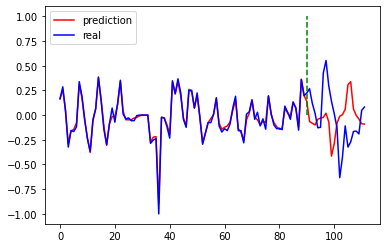

In [ ]:
all_data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
all_data_x = torch.from_numpy(all_data_x)

pred_model = LSTM_Regression(DAYS_FOR_TRAIN, 16, output_size=1, num_layers=2)
pred_model.load_state_dict(torch.load(f'/content/drive/MyDrive/models/epoch_1500.pth'))

pred_model.eval()
pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()

plt.plot(pred_test, 'r', label='prediction')
plt.plot(data_y, 'b', label='real')
plt.plot((TRAIN_SIZE, TRAIN_SIZE), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

In [ ]:
pred_test = pred_model(all_data_x)
pred_test.shape
pred_test.view(-1).data.numpy().shape

(112,)

In [ ]:
data_x.shape

(112, 3)

In [ ]:
DAYS_FOR_TRAIN = 3
TRAIN_SIZE = 94
epochs = 1000
lr = 1e-2

attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']

attr_train_result, attr_test_result = dict(), dict()
for index in range(30):
  data_x, data_y = create_dataset(trend_norm3[index], days_for_train=DAYS_FOR_TRAIN)
  train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
  train_y = torch.from_numpy(data_y[:TRAIN_SIZE].reshape(-1, 1, 1))
  test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
  test_y = torch.from_numpy(data_y[TRAIN_SIZE:].reshape(-1, 1, 1))

  model = LSTM_Regression(DAYS_FOR_TRAIN, 3, output_size=1, num_layers=2)
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  
  attr_train_result[attributes[index]] = []
  attr_test_result[attributes[index]] = []
  for i in range(epochs):
    model.train()
    out = model(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
      model.eval()
      test_out = model(test_x)
      test_loss = loss_function(test_out, test_y)
      print('Attribute: {}, Epoch: {}, Loss:{:.5f}, Test Loss:{:.5f}'.format(attributes[index], i+1, loss.item(), test_loss.item()))
      if i == 99 or i== epochs-1 or test_loss.item() <= min(attr_test_result[attributes[index]]):
        torch.save(model.state_dict(), f'model/{attributes[index]}_epoch_{i+1}.pth')
      attr_train_result[attributes[index]].append(loss.item())
      attr_test_result[attributes[index]].append(test_loss.item())

## predict

In [ ]:
!cp -r drive/MyDrive/lstm-model ./
!cp lstm-model/attr_01_epoch_0200.pth lstm-model/attr_01_epoch_0100.pth

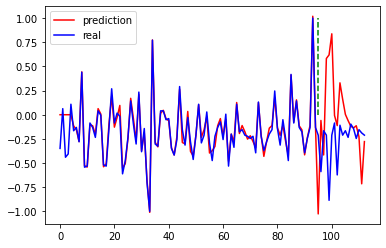

In [ ]:
predict_model = LSTM_Regression(DAYS_FOR_TRAIN, 4, output_size=1, num_layers=3)
predict_model.load_state_dict(torch.load('lstm-model/epoch_100.pth'))
predict_model = predict_model.eval()

data_x, data_y = create_dataset(trend_norm[1], days_for_train=DAYS_FOR_TRAIN)
data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
data_x = torch.from_numpy(data_x)

model.eval()
pred_test = model(data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(trend_data[1])

plt.plot(pred_test, 'r', label='prediction')
plt.plot(trend_norm[1], 'b', label='real')
plt.plot((95, 95), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

In [ ]:
min_all = all_data.min(axis=1)
max_all = all_data.max(axis=1)
norm_data = (all_data - np.reshape(min_all, (30, 1))) / np.reshape(max_all - min_all, (30, 1))
norm_data[0]

array([0.8353511 , 0.8353511 , 0.8958838 , 0.81113803, 0.7360775 ,
       0.84745765, 0.88377726, 0.8595642 , 0.80145276, 0.95883775,
       0.82566583, 0.72397095, 0.78450364, 0.7893462 , 0.76513314,
       0.9031477 , 0.85714287, 0.76755446, 0.6997579 , 0.66343826,
       0.89830506, 0.85714287, 0.9564165 , 1.        , 0.82566583,
       0.692494  , 0.7433414 , 0.8716707 , 0.81113803, 0.7772397 ,
       0.9394673 , 0.76755446, 0.7433414 , 0.5472155 , 0.18159807,
       0.527845  , 0.50121063, 0.40193704, 0.38256657, 0.5496368 ,
       0.56416464, 0.6319613 , 0.5617433 , 0.46004844, 0.4116223 ,
       0.6174334 , 0.6246973 , 0.5181598 , 0.5762712 , 0.527845  ,
       0.4164649 , 0.43341404, 0.55690074, 0.50363195, 0.45762712,
       0.60048425, 0.5472155 , 0.3898305 , 0.36077482, 0.39709443,
       0.39951575, 0.41404358, 0.4866828 , 0.38014528, 0.34140435,
       0.27360776, 0.39709443, 0.36077482, 0.37046006, 0.33414045,
       0.30992737, 0.2881356 , 0.30266345, 0.21549636, 0.38256

In [ ]:
DAYS_FOR_TRAIN = 5
TRAIN_SIZE = 90
epochs = 1000
lr = 1e-2

data_x, data_y = create_dataset(norm_data[0], days_for_train=DAYS_FOR_TRAIN)
train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
train_y = torch.from_numpy(data_y[:TRAIN_SIZE].reshape(-1, 1, 1))
test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
test_y = torch.from_numpy(data_y[TRAIN_SIZE:].reshape(-1, 1, 1))
model = LSTM_Regression(DAYS_FOR_TRAIN, 4, output_size=1, num_layers=3)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for i in range(epochs):
  out = model(train_x)
  loss = loss_function(out, train_y)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  if (i+1) % 100 == 0:
    model.eval()
    test_out = model(test_x)
    test_loss = loss_function(test_out, test_y)
    torch.save(model.state_dict(), f'model/epoch_{i+1}.pth')
    print('Epoch: {}, Loss:{:.5f}, Test Loss:{:.5f}'.format(i+1, loss.item(), test_loss.item()))
    model.train()

Epoch: 100, Loss:0.01386, Test Loss:0.06495
Epoch: 200, Loss:0.00771, Test Loss:0.03147
Epoch: 300, Loss:0.00473, Test Loss:0.01926
Epoch: 400, Loss:0.00402, Test Loss:0.02274
Epoch: 500, Loss:0.00430, Test Loss:0.02834
Epoch: 600, Loss:0.00373, Test Loss:0.03756
Epoch: 700, Loss:0.00324, Test Loss:0.04858
Epoch: 800, Loss:0.00376, Test Loss:0.04274
Epoch: 900, Loss:0.00279, Test Loss:0.06856
Epoch: 1000, Loss:0.00230, Test Loss:0.08910


In [ ]:
nn.

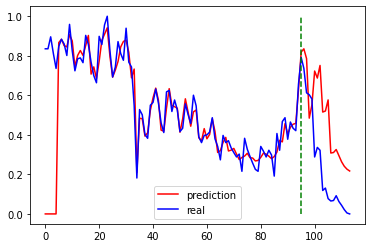

In [ ]:
predict_model = LSTM_Regression(DAYS_FOR_TRAIN, 4, output_size=1, num_layers=3)
predict_model.load_state_dict(torch.load('./model/epoch_1000.pth'))
predict_model = predict_model.eval()

data_x, data_y = create_dataset(norm_data[0], DAYS_FOR_TRAIN)
data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
data_x = torch.from_numpy(data_x)

pred_test = model(data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(norm_data[0])

plt.plot(pred_test, 'r', label='prediction')
plt.plot(norm_data[0], 'b', label='real')
plt.plot((95, 95), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

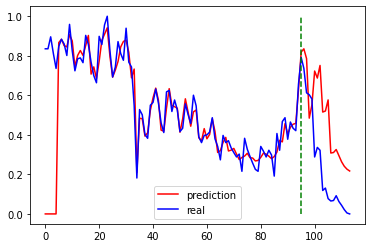

In [ ]:
data_x, data_y = create_dataset(norm_data[0], days_for_train=DAYS_FOR_TRAIN)
data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
data_x = torch.from_numpy(data_x)

model.eval()
pred_test = model(data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(norm_data[0])

plt.plot(pred_test, 'r', label='prediction')
plt.plot(norm_data[0], 'b', label='real')
plt.plot((95, 95), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

In [ ]:
yhat = model(data_x[90:]).view(-1).data.numpy()
y = norm_data[0][95:]
print(yhat)
print(y)
loss_function(torch.from_numpy(yhat.reshape(-1, 1)), torch.from_numpy(y.reshape(-1, 1)))

[0.7938378  0.6984738  0.75401706 0.16895711 0.4886644  0.6707237
 0.77468413 0.706005   0.50115013 0.53904736 0.55894375 0.30131474
 0.3199091  0.33892703 0.30645612 0.27314457 0.24866255 0.23200884
 0.22103693]
[0.79176754 0.7360775  0.6125908  0.6029056  0.5811138  0.2881356
 0.33656174 0.3220339  0.11864407 0.13075061 0.07748184 0.06537531
 0.06779661 0.09200969 0.06295399 0.04358353 0.02179177 0.00484262
 0.        ]


tensor(0.0891)

In [ ]:
yhat_trend, y_trend = [], []

for i in range(18):
  yhat_trend.append(yhat[i+1] - yhat[i])
  y_trend.append(y[i+1] - y[i])
yhat_trend = torch.from_numpy(np.array(yhat_trend))
y_trend = torch.from_numpy(np.array(y_trend))
yhat_trend, y_trend

(tensor([-0.0954,  0.0555, -0.5851,  0.3197,  0.1821,  0.1040, -0.0687, -0.2049,
          0.0379,  0.0199, -0.2576,  0.0186,  0.0190, -0.0325, -0.0333, -0.0245,
         -0.0167, -0.0110]),
 tensor([-0.0557, -0.1235, -0.0097, -0.0218, -0.2930,  0.0484, -0.0145, -0.2034,
          0.0121, -0.0533, -0.0121,  0.0024,  0.0242, -0.0291, -0.0194, -0.0218,
         -0.0169, -0.0048]))

In [ ]:
loss_function(yhat_trend, y_trend)

tensor(0.0433)

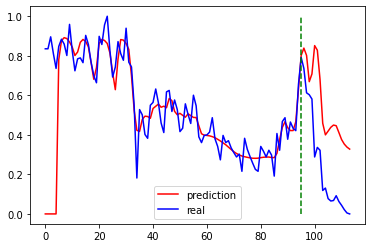

In [ ]:
data_x, data_y = create_dataset(norm_data[0], DAYS_FOR_TRAIN)
data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
data_x = torch.from_numpy(data_x)

pred_test = model(data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(norm_data[0])

plt.plot(pred_test, 'r', label='prediction')
plt.plot(norm_data[0], 'b', label='real')
plt.plot((95, 95), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

In [ ]:
yhat = model(data_x[90:]).view(-1).data.numpy()
y = norm_data[0][95:]
print(yhat)
print(y)
loss_function(torch.from_numpy(yhat.reshape(-1, 1)), torch.from_numpy(y.reshape(-1, 1)))

[0.7662272  0.8661309  0.8742557  0.8095602  0.65947056 0.6455662
 0.64743984 0.66717523 0.5756758  0.45694017 0.43792576 0.44496265
 0.45723355 0.4620473  0.4366197  0.39832965 0.37187243 0.3540719
 0.34042263]
[0.79176754 0.7360775  0.6125908  0.6029056  0.5811138  0.2881356
 0.33656174 0.3220339  0.11864407 0.13075061 0.07748184 0.06537531
 0.06779661 0.09200969 0.06295399 0.04358353 0.02179177 0.00484262
 0.        ]


tensor(0.1043)

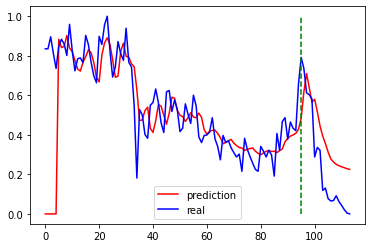

In [ ]:
data_x, data_y = create_dataset(norm_data[0], DAYS_FOR_TRAIN)
data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
data_x = torch.from_numpy(data_x)

pred_test = model(data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(norm_data[0])

plt.plot(pred_test, 'r', label='prediction')
plt.plot(norm_data[0], 'b', label='real')
plt.plot((95, 95), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

In [ ]:
yhat = model(data_x[90:]).view(-1).data.numpy()
y = norm_data[0][95:]
print(yhat)
print(y)
loss_function(torch.from_numpy(yhat.reshape(-1, 1)), torch.from_numpy(y.reshape(-1, 1)))

[0.82410705 0.73615426 0.58301204 0.54678905 0.5689666  0.6064093
 0.5260685  0.4405082  0.3894428  0.35422087 0.31274092 0.27806532
 0.26258743 0.25063854 0.24389361 0.23859027 0.23382682 0.22888458
 0.22518589]
[0.79176754 0.7360775  0.6125908  0.6029056  0.5811138  0.2881356
 0.33656174 0.3220339  0.11864407 0.13075061 0.07748184 0.06537531
 0.06779661 0.09200969 0.06295399 0.04358353 0.02179177 0.00484262
 0.        ]


tensor(0.0347)

In [ ]:
os.mkdir('model')
DAYS_FOR_TRAIN = 3
TRAIN_SIZE = 96
epochs = 1000
lr = 1e-2

index = 0
for train_x, train_y in create_train_data(norm_data, DAYS_FOR_TRAIN, TRAIN_SIZE):
  model = LSTM_Regression(DAYS_FOR_TRAIN, 4, output_size=1, num_layers=2)
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  index += 1
  for i in range(epochs):
    out = model(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
      txt = 'Index of Attr: {}, Epoch: {}, Loss:{:.5f}'.format(index, i+1, loss.item())
      print(txt)
      with open('result.txt', 'a') as res:
        res.write(txt+'\n')
      torch.save(model.state_dict(), f'./model/attr_{index:02d}_epoch_{i+1:04d}.pth')

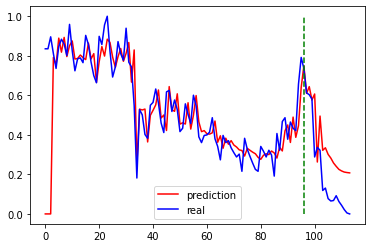

In [ ]:
predict_model = LSTM_Regression(DAYS_FOR_TRAIN, 4, output_size=1, num_layers=2)
predict_model.load_state_dict(torch.load('./model/attr_01_epoch_1200.pth'))

data_x, data_y = create_dataset(norm_data[0], DAYS_FOR_TRAIN)
data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
data_x = torch.from_numpy(data_x)

pred_test = predict_model(data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(norm_data[0])

plt.plot(pred_test, 'r', label='prediction')
plt.plot(norm_data[0], 'b', label='real')
plt.plot((train_size, train_size), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

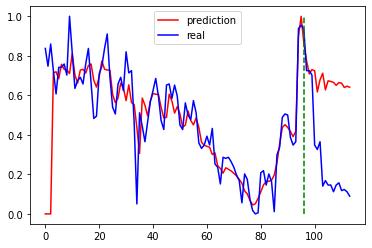

In [ ]:
predict_model = LSTM_Regression(DAYS_FOR_TRAIN, 4, output_size=1, num_layers=2)
predict_model.load_state_dict(torch.load('./model/attr_02_epoch_0300.pth'))

data_x, data_y = create_dataset(norm_data[1], DAYS_FOR_TRAIN)
data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
data_x = torch.from_numpy(data_x)

pred_test = predict_model(data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(norm_data[1])

plt.plot(pred_test, 'r', label='prediction')
plt.plot(norm_data[1], 'b', label='real')
plt.plot((train_size, train_size), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

In [ ]:
predict_model = LSTM_Regression(DAYS_FOR_TRAIN, 4, output_size=1, num_layers=3)
predict_model.load_state_dict(torch.load('./model/attr_02_epoch_0300.pth'))

data_x, data_y = create_dataset(norm_data[1], DAYS_FOR_TRAIN)
data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
data_x = torch.from_numpy(data_x)

pred_test = predict_model(data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(norm_data[1])

plt.plot(pred_test, 'r', label='prediction')
plt.plot(norm_data[1], 'b', label='real')
plt.plot((train_size, train_size), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

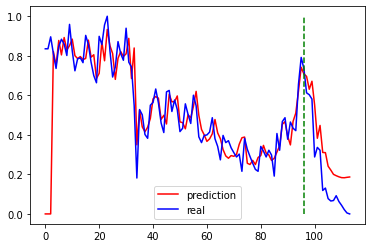

In [ ]:
model = model.eval() # 转换成测试模式

# 注意这里用的是全集 模型的输出长度会比原数据少DAYS_FOR_TRAIN 填充使长度相等再作图
data_x, data_y = create_dataset(data, DAYS_FOR_TRAIN)  # (seq_size, batch_size, feature_size)
data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
data_x = torch.from_numpy(data_x)

pred_test = model(data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(data)

plt.plot(pred_test, 'r', label='prediction')
plt.plot(data, 'b', label='real')
plt.plot((train_size, train_size), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()

In [ ]:
!cp -r lstm-model drive/MyDrive/

## rnn train

In [ ]:
class RNN_Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
    super(RNN_Net, self).__init__()
    self.rnn = nn.RNN(
      input_size=input_size,
      hidden_size=hidden_size,
      num_layers=num_layers,
    )
    for p in self.rnn.parameters():
      nn.init.normal_(p, mean=0.0, std=0.001)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden_prev):
    out, hidden_prev = self.rnn(x, hidden_prev)
    out = out.view(-1, hidden_size)
    out = self.linear(out)
    out = out.unsqueeze(dim=0)
    return out, hidden_prev

In [ ]:
input_size = 2
hidden_size = 16
DAYS_FOR_TRAIN = 2
TRAIN_SIZE = 90
lr=0.01

data_x, data_y = create_dataset(trend_norm3[0], DAYS_FOR_TRAIN)
train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
train_y = torch.from_numpy(data_y[:TRAIN_SIZE].reshape(-1, 1, 1))
test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
test_y = torch.from_numpy(data_y[TRAIN_SIZE:].reshape(-1, 1, 1))

model = RNN_Net(DAYS_FOR_TRAIN, hidden_size, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

hidden_prev = torch.zeros(1, 1, hidden_size)

for iter in range(6000):
  model.train()
  output, hidden_prev = model(train_x, hidden_prev)
  hidden_prev = hidden_prev.detach()

  loss = criterion(output, train_y)
  model.zero_grad()
  loss.backward()
  # for p in model.parameters():
  #     print(p.grad.norm())
  # torch.nn.utils.clip_grad_norm_(p, 10)
  optimizer.step()

  if iter % 100 == 0:
    print("Iteration: {} loss {}".format(iter, loss.item()))

  for i in range(epochs):
    model.train()
    out = model(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
      model.eval()
      test_out = model(test_x)
      test_loss = loss_function(test_out, test_y)
      print('Attribute: {}, Epoch: {}, Loss:{:.5f}, Test Loss:{:.5f}'.format(attributes[index], i+1, loss.item(), test_loss.item()))
      if i == 99 or i== epochs-1 or test_loss.item() <= min(attr_test_result[attributes[index]]):
        torch.save(model.state_dict(), f'model/{attributes[index]}_epoch_{i+1}.pth')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([90, 1, 1])) that is different to the input size (torch.Size([1, 90, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 0 loss 0.5107915997505188
Iteration: 100 loss 0.01711544394493103
Iteration: 200 loss 0.01659129373729229
Iteration: 300 loss 0.01632855273783207
Iteration: 400 loss 0.01625591143965721
Iteration: 500 loss 0.016247224062681198
Iteration: 600 loss 0.016246533021330833
Iteration: 700 loss 0.016246404498815536
Iteration: 800 loss 0.01624634861946106
Iteration: 900 loss 0.01624632254242897
Iteration: 1000 loss 0.016246311366558075
Iteration: 1100 loss 0.016246307641267776
Iteration: 1200 loss 0.016246307641267776
Iteration: 1300 loss 0.016246309503912926
Iteration: 1400 loss 0.016246311366558075
Iteration: 1500 loss 0.016246313229203224
Iteration: 1600 loss 0.016246315091848373
Iteration: 1700 loss 0.016246316954493523
Iteration: 1800 loss 0.016246318817138672
Iteration: 1900 loss 0.016246318817138672
Iteration: 2000 loss 0.01624632254242897
Iteration: 2100 loss 0.01624632440507412
Iteration: 2200 loss 0.01624632626771927
Iteration: 2300 loss 0.016246329993009567
Iteration: 2400

In [ ]:
all_data_x, all_data_y = create_dataset(trend_norm3[0], DAYS_FOR_TRAIN)
print(all_data_x.shape)
all_x = torch.from_numpy(all_data_x.reshape(-1, 1, DAYS_FOR_TRAIN))
model.eval()
pred, _ = model(all_x, hidden_prev)
print(pred.shape, all_y.shape)

(115, 2)
torch.Size([1, 115, 1]) torch.Size([1, 116, 1])


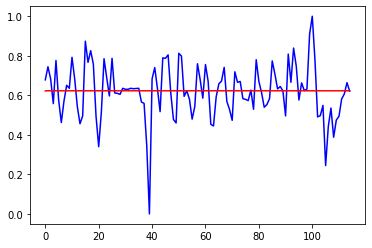

In [ ]:
plt.plot(all_data_y, 'b', label='real')
plt.plot(pred.view(-1).data.numpy(), 'r', label='pred')
plt.show()

In [ ]:
pred

tensor([[[0.6222],
         [0.6231],
         [0.6228],
         [0.6230],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6230],
         [0.6229],
         [0.6229],
         [0.6228],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6230],
         [0.6229],
         [0.6229],
         [0.6228],
         [0.6229],
         [0.6230],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6228],
         [0.6230],
         [0.6227],
         [0.6230],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.6230],
         [0.6229],
         [0.6229],
         [0.6229],
         [0.